#Multi-Modal RAG Application Video

This Notebook includes the following steps:-
1. Installing the necessary libraries
2. Importing the necessary libraries
3. Dowloading the source (Youtube Video)
4. Extracting the frames from video
5. Generating audio file for video
6. Dividing the audio into chunks and transcribing the chunks
7. Generating summaries of chunks and frames
8. Creation vector databse using `faiss-cpu` library
9. Saving the vector databse to local
10. Creation of custom llm and embedding model using [mdb.ai](https://mdb.ai/models) endpoints
9. Loading the saved vector database and creating a prompt template
9. Creating a function that retreives the relevant content for the user question. Where it is used as context while generating answer with the help of LLM..
9. Finally, testing.....


#Architecture
![Flowcharts (1)](https://github.com/chakka-guna-sekhar-venkata-chennaiah/Mutli-Modal-RAG-ChaBot/assets/110555361/ce045df8-f3c5-4d26-adc4-8fdb2540aa1f)


#1. Installing the necessary libraries

In [ ]:
!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python pytube moviepy pydub speechrecognition faiss-cpu langchain-community langchain-core

#2. Importing the necessary libraries

In [ ]:
import os
import uuid
import base64
import pytube
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
import speech_recognition as sr
from IPython.display import display, Image as IPImage
from PIL import Image
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever


#3. Dowloading the source (Youtube Video)

For the demonstration prupose, we are using the following Youtbe video.
[Link](https://www.youtube.com/watch?v=rRZdtAGInyQ&list=PLhRXULtLjLtfQ9COvoZg8Zg6ejTI3UPTG&index=1)

In [ ]:
# Download the YouTube video
youtube_url = 'https://www.youtube.com/watch?v=rRZdtAGInyQ&list=PLhRXULtLjLtfQ9COvoZg8Zg6ejTI3UPTG&index=1'
video = pytube.YouTube(youtube_url)
video_stream = video.streams.filter(progressive=True, file_extension='mp4').first()
video_path = video_stream.download()

#4. Extracting the frames from video

In [ ]:
# Extract frames from the video
output_frames_path = '/content/frames'
os.makedirs(output_frames_path, exist_ok=True)
clip = VideoFileClip(video_path)
duration = clip.duration

In [ ]:
frame_rate = 1  # Extract 1 frame per second
for t in range(0, int(duration), frame_rate):
    frame = clip.get_frame(t)
    frame_image_path = os.path.join(output_frames_path, f'frame_{t}.jpg')
    frame_image = Image.fromarray(frame)
    frame_image.save(frame_image_path)

#5. Generating audio file for the video

In [ ]:
# Convert video to audio
audio_path = '/content/audio.wav'
clip.audio.write_audiofile(audio_path)

MoviePy - Writing audio in /content/audio.wav


MoviePy - Done.


#6. Dividing the audio into chunks and transcribing the chunks

In [ ]:
# Transcribe audio to text
recognizer = sr.Recognizer()
audio = AudioSegment.from_wav(audio_path)
audio_chunks = audio[::60000]  # Split audio into 1-minute chunks

transcriptions = []
for i, chunk in enumerate(audio_chunks):
    chunk_path = f'/content/chunk_{i}.wav'
    chunk.export(chunk_path, format='wav')

    with sr.AudioFile(chunk_path) as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
        transcriptions.append(text)

transcribed_text = ' '.join(transcriptions)

#7. Generating summaries of chunks and frames

In [ ]:
# Use LangChain and OpenAI for summarization and processing
openai_api_key = 'your-openai-api-key'

# Summarize transcribed text
summary_prompt = """
Summarize the following text:
{text}
"""

summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

text_summary = summary_chain.run({'text': transcribed_text})



  warn_deprecated(

  warn_deprecated(

  warn_deprecated(



In [ ]:
# Create lists to store text elements, text summaries, image elements, and image summaries
text_elements = [transcribed_text]
text_summaries = [text_summary]
image_elements = []
image_summaries = []


In [ ]:
# Summarize images
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

In [ ]:
# Update the image summarization loop to store image elements and summaries
for frame_file in os.listdir(output_frames_path):
    frame_path = os.path.join(output_frames_path, frame_file)
    encoded_image = encode_image(frame_path)
    summary = summarize_image(encoded_image)
    image_summaries.append(summary)
    image_elements.append(encoded_image)


#8. Creation vector databse using faiss-cpu library

Installing `fiass-cpu` library

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 32.3 MB/s eta 0:00:00


In [ ]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

#9. Saving the vector databse to local

In [ ]:
vectorstore.save_local("faiss_index_audio") #You can checkout the file in your contents

#10. Creation of custom llm and embedding model using [mdb.ai](https://mdb.ai/models) endpoints

Before that, generate the api key from [mdb.ai](https://mdb.ai/models). By the God's grace 😀 the api is free......

In [ ]:
import base64
from openai import OpenAI
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from IPython.display import display, Image
from langchain.embeddings.base import Embeddings
from langchain.llms.base import LLM
from pydantic import BaseModel, Field

# Initialize OpenAI/MindsDB client
client = OpenAI(
    api_key="your-mdb.ai-api-key",
    base_url="https://llm.mdb.ai/"
)

class MDBEmbeddings(Embeddings):
    def __init__(self, client):
        super().__init__()
        self.client = client

    def embed_query(self, text):
        response = self.client.embeddings.create(
            model="text-embedding-ada-002",
            input=text,
            encoding_format="float"
        )
        return response.data[0].embedding

    def __call__(self, text):
        return self.embed_query(text)

    def embed_documents(self, texts):
        return [self.embed_query(text) for text in texts]

class MDBChatLLM(LLM):
    client: OpenAI = Field(...)

    def __init__(self, client):
        super().__init__()
        self.client = client

    def _call(self, prompt, **kwargs):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": prompt}],
            stream=False
        )
        return completion.choices[0].message.content

    @property
    def _llm_type(self) -> str:
        return "custom_mdb_chat"

# Instantiate the embeddings and LLM classes
embeddings = MDBEmbeddings(client=client)
mdb_chat_llm = MDBChatLLM(client=client)

#11. Loading the saved vector database and creating a prompt template

In [ ]:
# Load the FAISS index with custom embeddings
db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

# Define the prompt template for the LLMChain
prompt_template = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.
Answer the question based only on the following context, which can include text, images, and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much detail as possible.
Answer:
"""



#12. Creating a function that retreives the relevant content for the user question. Where it is used as context while generating answer with the help of LLM..

In [ ]:
# Setup the LLMChain with the custom chat model
qa_chain = LLMChain(llm=mdb_chat_llm, prompt=PromptTemplate.from_template(prompt_template))

# Query the vectorstore
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images


The key points discussed in the presentation slides titled "Pros" are as follows:

1. **Minimal Effort** - The topic requires minimal effort; clear instructions or questions are sufficient.
2. **Accessible for Everyone** - No technical expertise is needed to engage with the topic.
3. **Broad Task Range** - The topic is versatile and applicable to various tasks without the need for significant modifications.

These points highlight the ease of engagement, inclusivity, and versatility of the discussed topic, as presented in the slides attributed to "Kalyan KS @ Akmmus AI Labs."


#13. Testing..

In [ ]:
result, relevant_images = answer("Can you summarize the key points discussed in the video?")
print(result) #retreived result from LLM


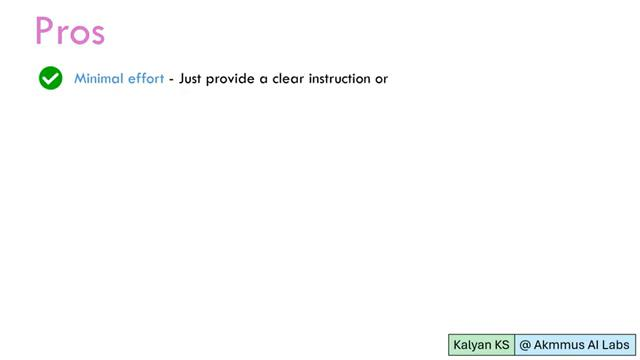

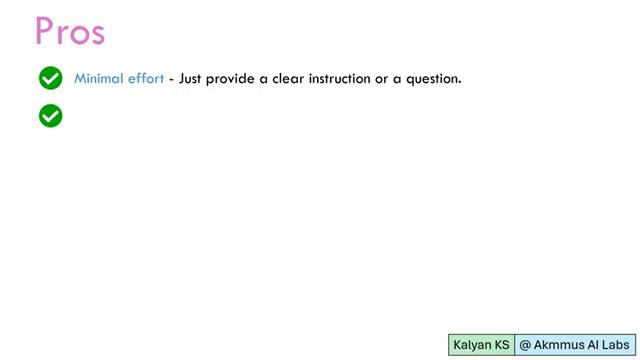

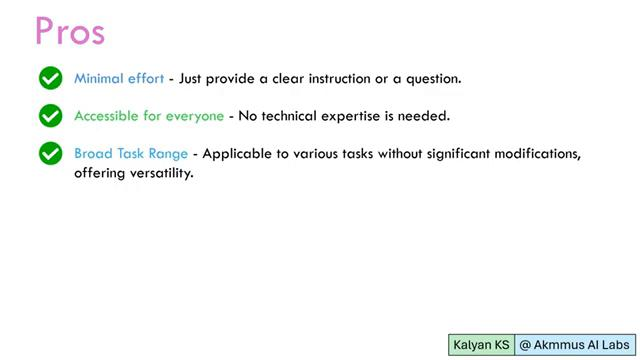

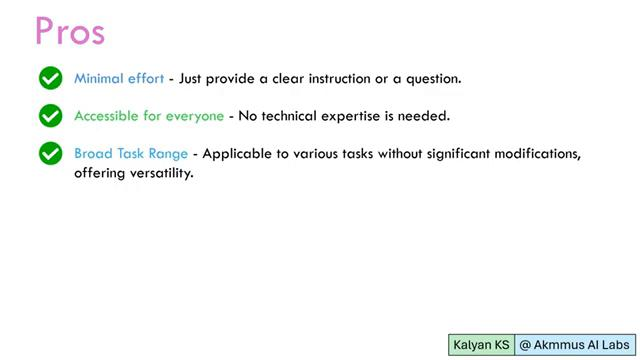

In [ ]:
#Displaying all relevant image from relevant images list
if len(relevant_images)>0:
  for i in range(len(relevant_images)):
    image_data = base64.b64decode(relevant_images[i])
    display(Image(image_data))



#Conclusion

Checkout the [Github Link](https://github.com/chakka-guna-sekhar-venkata-chennaiah/Mutli-Modal-RAG-ChaBot) for Streamlit Deployment....

If you appreciate this project, kindly show your support by ⭐ starring the repository and voting for me on Quria. Your encouragement would mean a lot! Additionally, I'd be grateful if you could like 👍, share, and follow me on [LinkedIn](https://linkedin.com/in/chakka-guna-sekhar-venkata-chennaiah-7a6985208/) to stay connected and get updates on my latest work. Thank you! 🙏✨